# **Dive Deeper: Unsupervised Learning**

- Bagian 6 Audit Analytics untuk Bank Rakyat Indonesia
- *Last Updated*: December 2023

___



# Import Library

In [95]:
# Menyembunyikan Peringatan
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Komputasi Matematika dan Array
import math
import numpy as np

# Persiapan Data
import pandas as pd

# Visualisasi Data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
from helper import *

# Paket Machine Learning
import scipy.stats as stats
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyod.models.lof import LOF

# Paket Lainnya
from numpy.linalg import eig
from helper import biplot_pca
plt.style.use('seaborn-v0_8-whitegrid')


---


# TASK:

Dalam tugas kali ini, anda dapat melakukan anomaly detection berdasarkan alur yang telah dipelajari di kelas dengan menggunakan dataset [berikut](https://www.kaggle.com/ealaxi/paysim1). 

Dataset ini merupakan dataset sintetik yang dihasilkan menggunakan simulator bernama PaySim. Dataset berisi transaksi keuangan dengan observasi penipuan. PaySim mensimulasikan transaksi uang seluler berdasarkan sampel transaksi asli yang diambil dari catatan keuangan satu bulan dari layanan uang seluler yang diterapkan di negara Afrika. Log asli disediakan oleh perusahaan multinasional, penyedia layanan keuangan seluler, yang saat ini beroperasi di lebih dari 14 negara di seluruh dunia.

# Step-by-Step: PCA Analysis




langkah-langkah ini, kita akan melakukan analisis Principal Component Analysis (PCA), termasuk proses hingga pembuatan dataframe baru dari hasil komponen utama (Principal Components).

In [4]:
# read dataset

credit_raw = pd.read_csv('fraud.csv')
credit_raw.head()

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   398  CASH_OUT   229428.85  C1722971247           0.00             0.0   
1   355  CASH_OUT    65031.88   C353283462           0.00             0.0   
2    95  TRANSFER  8775594.43  C1917836086     8775594.43             0.0   
3   239  TRANSFER   495991.64  C1628056782      495991.64             0.0   
4   498  CASH_OUT   207261.07  C1856398520      207261.07             0.0   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0   C992110216      1226936.33      1456365.17        0               0  
1   C757039269       118417.06       183448.94        0               0  
2  C1694421805            0.00            0.00        1               0  
3   C913892512            0.00            0.00        1               0  
4  C1898820013        48221.70       255482.77        1               0

**Rangkuman Dataset:**

Setiap fitur dari data dijelaskan sebagai berikut:

1. **step**: Mewakili satuan waktu dalam real world. Dalam hal ini, 1 langkah setara dengan 1 jam waktu. Total langkah adalah 744 (simulasi selama 30 hari).

2. **type**: Jenis transaksi, [CASH-IN, CASH-OUT, DEBIT, PAYMENT, dan TRANSFER].

3. **amount**: Jumlah transaksi dalam mata uang lokal.

4. **nameOrig**: Pelanggan yang memulai transaksi.

5. **oldbalanceOrg**: Saldo awal sebelum transaksi dilakukan.

6. **newbalanceOrig**: Saldo baru pelanggan pemulai setelah transaksi.

7. **nameDest**: Pelanggan yang menjadi penerima transaksi.

8. **oldbalanceDest**: Saldo awal penerima sebelum transaksi dilakukan.

9. **newbalanceDest**: Saldo baru penerima setelah transaksi.

10. **isFraud**: Ini adalah transaksi yang dilakukan oleh agen penipu di dalam simulasi. Dalam kumpulan data khusus ini, perilaku penipuan agen bertujuan untuk mendapatkan keuntungan dengan mengambil kendali atau rekening pelanggan dan mencoba mengosongkan dana dengan mentransfer ke rekening lain dan kemudian menguangkannya dari sistem.

11. **isFlaggedFraud**: Model bisnis ini bertujuan untuk mengontrol transfer besar-besaran dari satu akun ke akun lainnya dan menandai upaya ilegal. Upaya ilegal dalam kumpulan data ini adalah upaya mentransfer lebih dari 200.000 dalam satu transaksi.

Sebelum melanjutkan dengan algoritma, beberapa langkah pembersihan data perlu dilakukan. Pertama, kita perlu mengubah jenis variabel yang salah. Di sini, variabel "type" perlu diubah menjadi faktor. Kita juga perlu menghapus variabel "nameOrig" dan "nameDest" karena mengandung banyak nilai unik.

In [6]:
credit_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   nameOrig        50000 non-null  object 
 4   oldbalanceOrg   50000 non-null  float64
 5   newbalanceOrig  50000 non-null  float64
 6   nameDest        50000 non-null  object 
 7   oldbalanceDest  50000 non-null  float64
 8   newbalanceDest  50000 non-null  float64
 9   isFraud         50000 non-null  int64  
 10  isFlaggedFraud  50000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 4.2+ MB


In [7]:
credit_raw.describe(include='all')

step      type        amount     nameOrig  oldbalanceOrg  \
count   50000.000000     50000  5.000000e+04        50000   5.000000e+04   
unique           NaN         5           NaN        50000            NaN   
top              NaN  CASH_OUT           NaN  C1722971247            NaN   
freq             NaN     18854           NaN            1            NaN   
mean      263.918380       NaN  3.931274e+05          NaN   9.522699e+05   
std       163.539427       NaN  1.239935e+06          NaN   2.980458e+06   
min         1.000000       NaN  0.000000e+00          NaN   0.000000e+00   
25%       157.000000       NaN  1.703956e+04          NaN   0.000000e+00   
50%       254.000000       NaN  1.020985e+05          NaN   2.563800e+04   
75%       355.000000       NaN  2.670287e+05          NaN   2.520595e+05   
max       743.000000       NaN  6.988673e+07          NaN   5.958504e+07   

        newbalanceOrig    nameDest  oldbalanceDest  newbalanceDest  \
count     5.000000e+04       50000    5.000000e+04    5.000000e+04   
unique             NaN       48280             NaN             NaN   
top                NaN  C716972827             NaN             NaN   
freq               NaN           4             NaN             NaN   
mean      7.322388e+05         NaN    1.006242e+06    1.233634e+06   
std       2.755142e+06         NaN    3.433557e+06    3.781655e+06   
min       0.000000e+00         NaN    0.000000e+00    0.000000e+00   
25%       0.000000e+00         NaN    0.000000e+00    0.000000e+00   
50%       0.000000e+00         NaN    5.801229e+04    1.903888e+05   
75%       8.226374e+04         NaN    8.075893e+05    1.111801e+06   
max       4.958504e+07         NaN    2.362305e+08    2.367265e+08   

             isFraud  isFlaggedFraud  
count   50000.000000    50000.000000  
unique           NaN             NaN  
top              NaN             NaN  
freq             NaN             NaN  
mean        0.164260        0.000320  
std         0.370515        0.017886  
min         0.000000        0.000000  
25%         0.000000        0.000000  
50%         0.000000        0.000000  
75%         0.000000        0.000000  
max         1.000000        1.000000

---

## Exploratory Data Analysis

1. Silahkan lakukan tahapan EDA dataset
2. Lakukan analisis dari dataset tersebut

## Data Preprocessing

**1.  Check Missing Values**

In [9]:
credit_raw.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**2. Cek Duplikat Data**

In [12]:
credit_raw.duplicated().any()

False

**3. Feature Selection**

In [17]:
cat = ['nameOrig', 'nameDest']

credit_raw_1 = credit_raw.drop(columns=cat).copy()
credit_raw_1.head()

step      type      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0   398  CASH_OUT   229428.85           0.00             0.0      1226936.33   
1   355  CASH_OUT    65031.88           0.00             0.0       118417.06   
2    95  TRANSFER  8775594.43     8775594.43             0.0            0.00   
3   239  TRANSFER   495991.64      495991.64             0.0            0.00   
4   498  CASH_OUT   207261.07      207261.07             0.0        48221.70   

   newbalanceDest  isFraud  isFlaggedFraud  
0      1456365.17        0               0  
1       183448.94        0               0  
2            0.00        1               0  
3            0.00        1               0  
4       255482.77        1               0

**4. Data wrangling**

In [19]:
credit_raw_1_enc = pd.get_dummies(credit_raw_1,
                              columns= ['type'],
                              drop_first=True, 
                              dtype='int')
credit_raw_1_enc.head()

step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0   398   229428.85           0.00             0.0      1226936.33   
1   355    65031.88           0.00             0.0       118417.06   
2    95  8775594.43     8775594.43             0.0            0.00   
3   239   495991.64      495991.64             0.0            0.00   
4   498   207261.07      207261.07             0.0        48221.70   

   newbalanceDest  isFraud  isFlaggedFraud  type_CASH_OUT  type_DEBIT  \
0      1456365.17        0               0              1           0   
1       183448.94        0               0              1           0   
2            0.00        1               0              0           0   
3            0.00        1               0              0           0   
4       255482.77        1               0              1           0   

   type_PAYMENT  type_TRANSFER  
0             0              0  
1             0              0  
2             0              1  
3             0              1  
4             0              0

**5. Ambil variabel dataset numerik**

In [20]:
credit_raw_num = credit_raw_1.select_dtypes('number')
credit_raw_num.head()

step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0   398   229428.85           0.00             0.0      1226936.33   
1   355    65031.88           0.00             0.0       118417.06   
2    95  8775594.43     8775594.43             0.0            0.00   
3   239   495991.64      495991.64             0.0            0.00   
4   498   207261.07      207261.07             0.0        48221.70   

   newbalanceDest  isFraud  isFlaggedFraud  
0      1456365.17        0               0  
1       183448.94        0               0  
2            0.00        1               0  
3            0.00        1               0  
4       255482.77        1               0

![Number of Transaction Based on Type](newplot.png)

Plot diatas hanya menampilkan jumlah transaksi berdasarkan tipe nya dari dataset diatas. Mayoritas transaksi berasal dari Cash out, dengan lebih dari dua juta transaksi. Transaksi berikut adalah Pembayaran, Tunai dan Debit. 

Kita juga bisa memvisualisasikan sebaran transaksi penipuan berdasarkan jenis.

Untuk melakukan explor lebih jauh, coba lakukan pengecekan jenis transaksi apa saja yang banyak transaksi fraud nya.

<Axes: xlabel='type', ylabel='Count'>

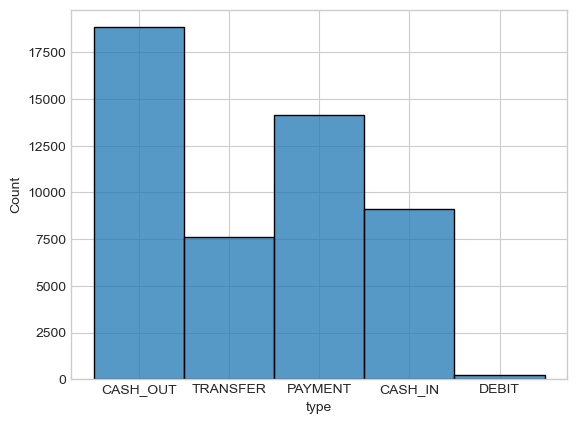

In [37]:
sns.histplot(credit_raw_1_temp['type'])

In [27]:
## Contoh kode

# # Menghitung total transaksi penipuan berdasarkan jenis transaksi 
total_fraud = credit_raw_1[credit_raw_1['isFraud'] == 1].groupby('type').size().reset_index(name='count').sort_values(by='count', ascending=False)
total_fraud

type  count
0  CASH_OUT   4116
1  TRANSFER   4097

In [40]:
total_fraud2 = credit_raw_1.groupby(['type']).sum()['isFraud']
total_fraud2

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64

Setelah mengatahui, untuk alur selanjutnya silahkan gunakan dataset yang sudah terfilter tersebut (berdasarkan 2 jenis transaksi terbesar)

In [43]:
# code here
credit_raw_1_drop = credit_raw_1[credit_raw_1['type'].isin(['CASH_OUT', 'TRANSFER'])]
credit_raw_1_drop.head()

step      type      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0   398  CASH_OUT   229428.85           0.00             0.0      1226936.33   
1   355  CASH_OUT    65031.88           0.00             0.0       118417.06   
2    95  TRANSFER  8775594.43     8775594.43             0.0            0.00   
3   239  TRANSFER   495991.64      495991.64             0.0            0.00   
4   498  CASH_OUT   207261.07      207261.07             0.0        48221.70   

   newbalanceDest  isFraud  isFlaggedFraud  
0      1456365.17        0               0  
1       183448.94        0               0  
2            0.00        1               0  
3            0.00        1               0  
4       255482.77        1               0

**6. Data Scaling**

**Visualisasi Plot Skewness:**

Sebelum melakukan scaling data, kita pertama-tama mengevaluasi skewness dari kolom-kolom numerik dalam dataset.

<Axes: ylabel='Density'>

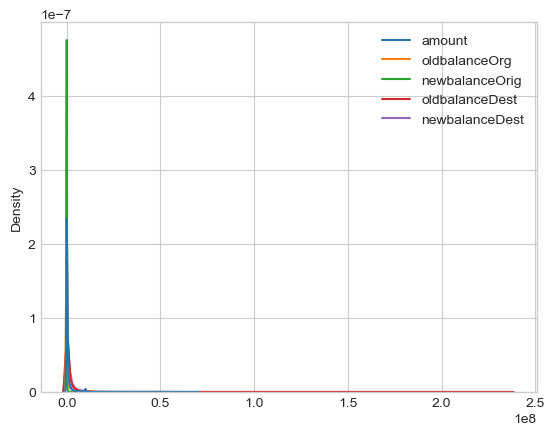

In [48]:
# code here
sns.kdeplot(credit_raw_1_drop.select_dtypes('float64'))

<Axes: xlabel='step', ylabel='Density'>

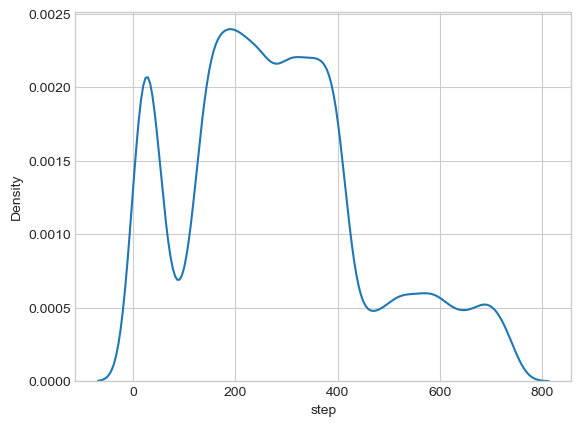

In [49]:
sns.kdeplot(credit_raw_1_drop['step'])

In [50]:
credit_raw_1_drop.select_dtypes('number').skew()

step               0.550785
amount             7.271632
oldbalanceOrg     10.234444
newbalanceOrig    25.470485
oldbalanceDest    23.626151
newbalanceDest    20.720318
isFraud            0.820701
isFlaggedFraud    40.644806
dtype: float64

In [68]:
kolom_value = credit_raw_1_drop.select_dtypes('number').columns[:6] # drop(index=(['isFraud', 'isFlaggedFraud']))
credit_raw_1_drop_wo_y =  credit_raw_1_drop[kolom_value].copy()
credit_raw_1_drop_wo_y

step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0       398   229428.85           0.00             0.0      1226936.33   
1       355    65031.88           0.00             0.0       118417.06   
2        95  8775594.43     8775594.43             0.0            0.00   
3       239   495991.64      495991.64             0.0            0.00   
4       498   207261.07      207261.07             0.0        48221.70   
...     ...         ...            ...             ...             ...   
49984   544   146201.44           0.00             0.0       459624.88   
49986   379   118961.30           0.00             0.0      1506057.47   
49987    12   165695.51       92374.00             0.0            0.00   
49989   588   723476.51           0.00             0.0      6234374.46   
49990   281    41858.49           0.00             0.0       564428.77   

       newbalanceDest  
0          1456365.17  
1           183448.94  
2                0.00  
3                0.00  
4           255482.77  
...               ...  
49984       605826.32  
49986      1625018.77  
49987       165695.51  
49989      6957850.97  
49990       606287.26  

[26477 rows x 6 columns]

**Melakukan scaling data**

Setelah memahami skewness data, kita dapat melanjutkan dengan tahap kedua, yaitu melakukan scaling data menggunakan z-score normalization. Hal ini dilakukan untuk menghilangkan penyimpangan skewness dan memastikan distribusi data mendekati distribusi normal standar. Rangkuman kalimat untuk tahap kedua dapat mencakup proses scaling data menggunakan z-score normalization untuk memastikan konsistensi dalam rentang nilai dan meningkatkan keterbacaan model.

In [125]:
# code here
scaler = StandardScaler()

credit_raw_1_drop_wo_y_scale = scaler.fit_transform(credit_raw_1_drop_wo_y)
credit_raw_1_drop_wo_y_scale = pd.DataFrame(credit_raw_1_drop_wo_y_scale, columns=kolom_value)
credit_raw_1_drop_wo_y_scale

step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0      0.657533 -0.271206      -0.256150       -0.064207       -0.028364   
1      0.415830 -0.370860      -0.256150       -0.064207       -0.290162   
2     -1.045627  4.909300       3.895668       -0.064207       -0.318128   
3     -0.236204 -0.109622      -0.021491       -0.064207       -0.318128   
4      1.219631 -0.284644      -0.158092       -0.064207       -0.306740   
...         ...       ...            ...             ...             ...   
26472  1.478197 -0.321657      -0.256150       -0.064207       -0.209579   
26473  0.550734 -0.338170      -0.256150       -0.064207        0.037555   
26474 -1.512169 -0.309840      -0.212447       -0.064207       -0.318128   
26475  1.725520  0.028275      -0.256150       -0.064207        1.154236   
26476 -0.000123 -0.384908      -0.256150       -0.064207       -0.184828   

       newbalanceDest  
0           -0.076712  
1           -0.346309  
2           -0.385162  
3           -0.385162  
4           -0.331052  
...               ...  
26472       -0.256851  
26473       -0.040992  
26474       -0.350069  
26475        1.088472  
26476       -0.256754  

[26477 rows x 6 columns]

In [83]:
credit_raw_1_drop_scale = credit_raw_1_drop_wo_y_scale.copy()
credit_raw_1_drop_scale[['isFraud', 'isFlaggedFraud']] = credit_raw_1_drop[['isFraud', 'isFlaggedFraud']]
credit_raw_1_drop_scale.head()

step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0  0.657533 -0.271206      -0.256150       -0.064207       -0.028364   
1  0.415830 -0.370860      -0.256150       -0.064207       -0.290162   
2 -1.045627  4.909300       3.895668       -0.064207       -0.318128   
3 -0.236204 -0.109622      -0.021491       -0.064207       -0.318128   
4  1.219631 -0.284644      -0.158092       -0.064207       -0.306740   

   newbalanceDest  isFraud  isFlaggedFraud  
0       -0.076712      0.0             0.0  
1       -0.346309      0.0             0.0  
2       -0.385162      1.0             0.0  
3       -0.385162      1.0             0.0  
4       -0.331052      1.0             0.0

### Aplikasi PCA: Reduksi Dimensi pada Data credit

Pertama, mari kita lihat matriks kovariansi dari dataset yang sudah di scaled:

**7. Cek korelasi data**

In [84]:
# code here
credit_raw_1_drop_wo_y_scale.corr()

step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000  0.142136       0.154401        0.062018   
amount          0.142136  1.000000       0.764629        0.295896   
oldbalanceOrg   0.154401  0.764629       1.000000        0.743173   
newbalanceOrig  0.062018  0.295896       0.743173        1.000000   
oldbalanceDest -0.014932  0.099011      -0.051185       -0.017375   
newbalanceDest  0.004665  0.310065       0.052236       -0.021711   

                oldbalanceDest  newbalanceDest  
step                 -0.014932        0.004665  
amount                0.099011        0.310065  
oldbalanceOrg        -0.051185        0.052236  
newbalanceOrig       -0.017375       -0.021711  
oldbalanceDest        1.000000        0.950805  
newbalanceDest        0.950805        1.000000

### Principal Component Analysis menggunakan library [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

Setelah melakukan scaling, kita dapat menerapkan PCA pada data yang telah diubah skala, seperti yang ditunjukkan dalam kode berikut: 

In [126]:
pca = PCA(n_components = credit_raw_1_drop_wo_y_scale.shape[1], # jumlah pca yang dihasilkan
          svd_solver='full') # implementasi full svd sehingga mendapatkan semua PC yang terbentuk

pca.fit(credit_raw_1_drop_wo_y_scale) # menghitung PCA
# atau dapat menggunakan pca = pca.fit_transform(scale(balance_scaled))

PCA(n_components=6, svd_solver='full')

In [135]:
# opsional
credit_raw_1_drop_wo_y_scale_pca = pd.DataFrame(pca.fit_transform(credit_raw_1_drop_wo_y_scale), 
                          columns=pca.get_feature_names_out())
credit_raw_1_drop_wo_y_scale_pca

pca0      pca1      pca2      pca3      pca4      pca5
0     -0.259164 -0.010785 -0.663760  0.267925  0.051610 -0.004463
1     -0.492294 -0.324101 -0.430261  0.226179  0.024843  0.004132
2      4.546919 -1.810400  1.154774 -3.763749 -0.841435 -0.682006
3     -0.327668 -0.397875  0.210784 -0.090174 -0.051717 -0.032286
4     -0.271149 -0.427622 -1.202124  0.314891  0.015136  0.021303
...         ...       ...       ...       ...       ...       ...
26472 -0.265177 -0.308164 -1.457875  0.416462  0.063525  0.000937
26473 -0.284491  0.068079 -0.557035  0.307445  0.010612 -0.000266
26474 -0.721270 -0.198889  1.434637 -0.193254 -0.016522  0.008578
26475  0.692757  1.383347 -1.689840  0.552111  0.099856 -0.032684
26476 -0.508068 -0.163075 -0.026081  0.180408 -0.001517  0.004097

[26477 rows x 6 columns]

In [129]:
# menampilkan banyaknya PC yang terbentuk dengan explained_variance_ratio
pca.explained_variance_ratio_

array([0.38754519, 0.32316292, 0.16273136, 0.11212184, 0.01150232,
       0.00293638])

In [130]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.75, 71.07, 87.34, 98.55, 99.7 , 99.99])

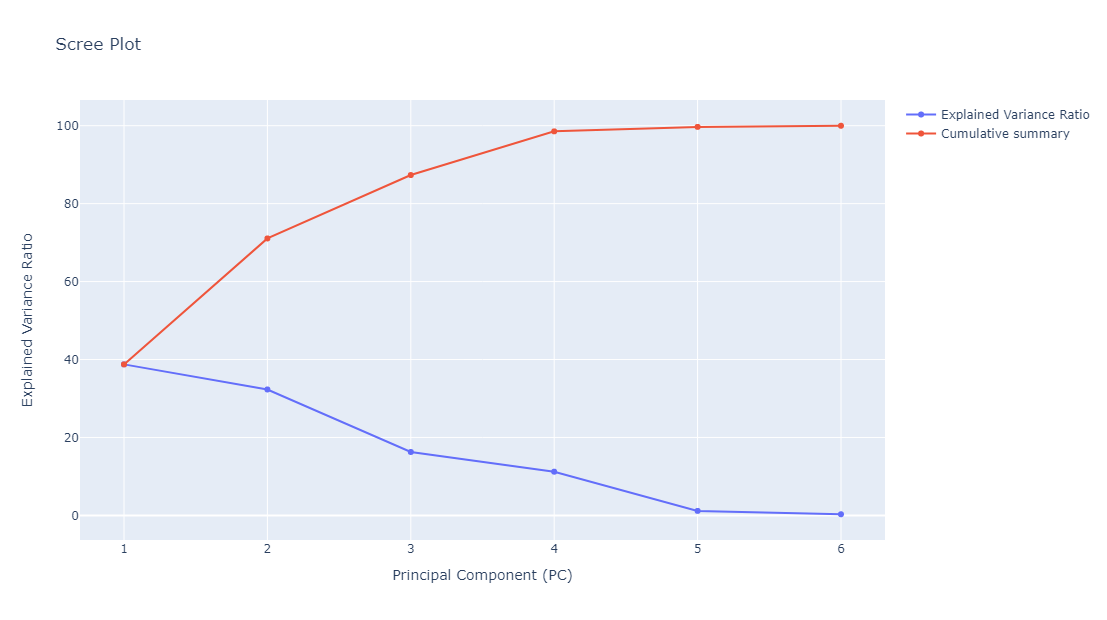

In [109]:
# Hitung proporsi variasi yang dijelaskan oleh setiap komponen utama
explained_var_ratio = pca.explained_variance_ratio_

# Buat scree plot menggunakan plotly
fig = go.Figure()

# Plot proporsi variasi yang dijelaskan
fig.add_trace(go.Scatter(x=list(range(1, len(explained_var_ratio) + 1)), 
                         y=explained_var_ratio*100, mode='lines+markers', 
                         name='Explained Variance Ratio'))

fig.add_trace(go.Scatter(x=list(range(1, len(explained_var_ratio) + 1)), 
                         y=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100), mode='lines+markers', 
                         name='Cumulative summary'))

# Atur layout dan tampilkan
fig.update_layout(title='Scree Plot',
                  xaxis_title='Principal Component (PC)',
                  yaxis_title='Explained Variance Ratio',
                  showlegend=True,
                  width=800, height=620)

pyo.iplot(fig, 'Scree')

## Visualisasi PCA

1. Silahkan buat visualisasi
2. cek variable important

In [132]:
credit_raw_1_drop_wo_y_scale.shape

(26477, 6)

In [111]:
credit_raw_1_drop_wo_y_scale_pca.head()

pca0      pca1      pca2      pca3      pca4      pca5
0  0.145087 -0.084372 -0.966677  0.192065  0.021834  0.000766
1  0.540498 -0.065675 -0.036491 -0.665608  0.404910 -0.308593
2  0.581877 -0.293886  0.087994 -0.045307 -0.715891  0.229684
3  0.445655 -0.285477  0.236968  0.680815  0.440846 -0.076722
4  0.232317  0.652296  0.017287  0.233476 -0.289829 -0.617841

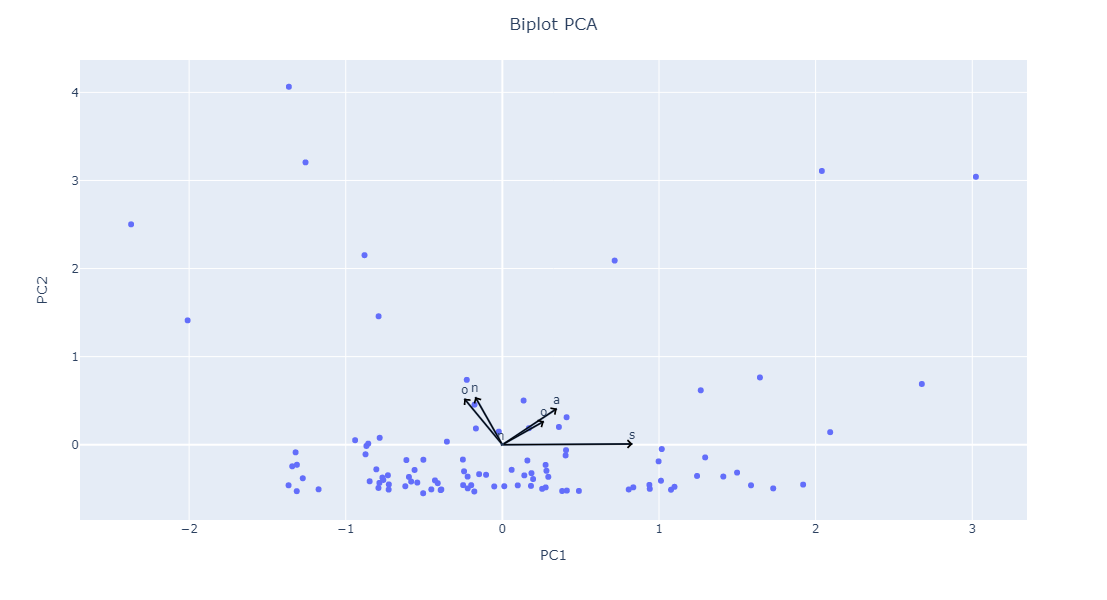

In [150]:
# code here
biplot_plotly(credit_raw_1_drop_wo_y_scale, pca)

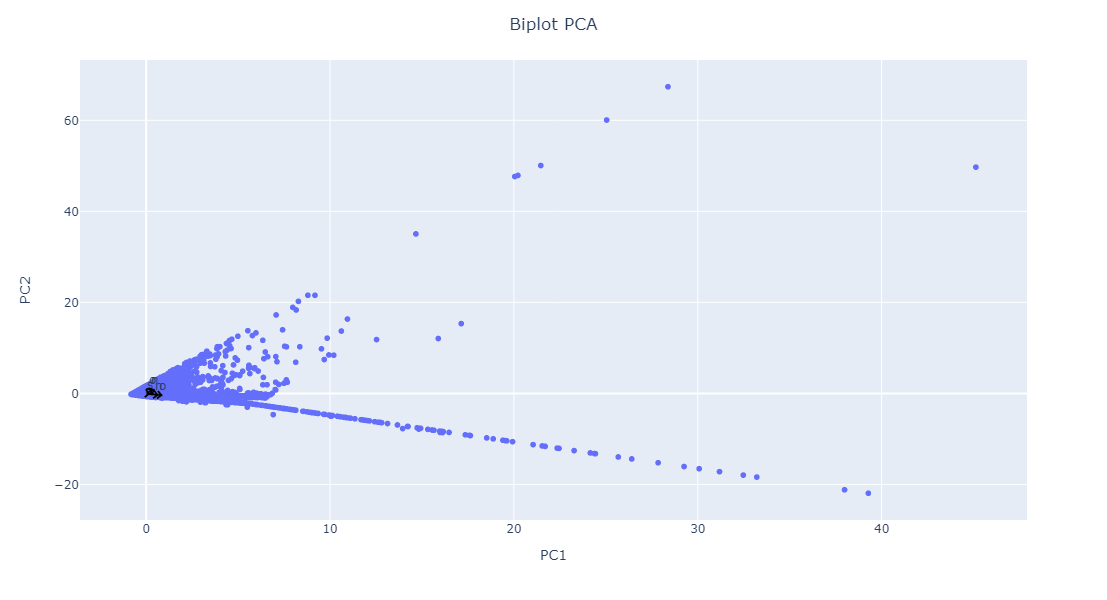

In [134]:
# ambil nama tiap kolom balance_saled sesuai urutan di df
features = list(credit_raw_1_drop_wo_y_scale.columns.values) 
# hasil PCA. sama seperti objek transform_ di atas, tapi beda nama kolom
components = pca.fit_transform(credit_raw_1_drop_wo_y_scale) 
# dot product/perkalian matriks antara eigenvector dengan akar kuadrat eigen value
loadings = pca.components_.T * np.sqrt(pca.explained_variance_) 

# Pilih fitur dengan loadings terbesar pada PC1 dan PC2
important_features = [features[i][0] for i in np.abs(loadings[:, :5]).argmax(axis=0)]

fig = px.scatter(components, x=0, y=1, hover_name=list(range(len(components))))

for i, feature in enumerate(features):
    # Hanya tambahkan garis panah dan anotasi untuk fitur yang penting
    if feature[0] in important_features:
        fig.add_shape(
            type='line',
            x0=0, y0=0,
            x1=loadings[i, 0],
            y1=loadings[i, 1],
        )

        fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text=features[i][0], 
        )

        fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xref='x', yref='y',
            axref='x', ayref='y',
            text='',  # if you want only the arrow
            showarrow=True,
            arrowhead=4,
            arrowsize=1.5,
            arrowwidth=1,
            arrowcolor='black'
        )

# Plotly figure layout
fig.update_layout(title='Biplot PCA', title_x=0.5, width=800, height=600)
fig.update_xaxes(title_text='PC1')
fig.update_yaxes(title_text='PC2')
fig.show()


In [119]:
# final_credit = credit_raw_1_drop_wo_y_scale.copy()
# final_credit.head()

step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0  0.657533 -0.271206      -0.256150       -0.064207       -0.028364   
1  0.415830 -0.370860      -0.256150       -0.064207       -0.290162   
2 -1.045627  4.909300       3.895668       -0.064207       -0.318128   
3 -0.236204 -0.109622      -0.021491       -0.064207       -0.318128   
4  1.219631 -0.284644      -0.158092       -0.064207       -0.306740   

   newbalanceDest  
0       -0.076712  
1       -0.346309  
2       -0.385162  
3       -0.385162  
4       -0.331052

# Studi Kasus Local Outlier Factor (LOF): Deteksi Anomali dengan Menggunakan Library PyOD

# Local Outlier Factor

PyOD LOF Documentation. https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.lof

## Membuat Model LOF


In [138]:
credit_raw_1_drop_wo_y_scale_pca

pca0      pca1      pca2      pca3      pca4      pca5
0     -0.259164 -0.010785 -0.663760  0.267925  0.051610 -0.004463
1     -0.492294 -0.324101 -0.430261  0.226179  0.024843  0.004132
2      4.546919 -1.810400  1.154774 -3.763749 -0.841435 -0.682006
3     -0.327668 -0.397875  0.210784 -0.090174 -0.051717 -0.032286
4     -0.271149 -0.427622 -1.202124  0.314891  0.015136  0.021303
...         ...       ...       ...       ...       ...       ...
26472 -0.265177 -0.308164 -1.457875  0.416462  0.063525  0.000937
26473 -0.284491  0.068079 -0.557035  0.307445  0.010612 -0.000266
26474 -0.721270 -0.198889  1.434637 -0.193254 -0.016522  0.008578
26475  0.692757  1.383347 -1.689840  0.552111  0.099856 -0.032684
26476 -0.508068 -0.163075 -0.026081  0.180408 -0.001517  0.004097

[26477 rows x 6 columns]

In [152]:
# Menggunakan LOF dari PyOD (Python Outlier Detection)

lof_model = LOF()
lof_label = lof_model.fit_predict(credit_raw_1_drop_wo_y_scale_pca)
lof_label

array([0, 0, 0, ..., 0, 0, 0])

**Cek jumlah antara LOF 0 (normal) dan LOF 1 (anomali)**

In [153]:
# code here
pd.Series(lof_label).value_counts()

0    23829
1     2648
Name: count, dtype: int64

In [154]:
# code here
pd.Series(lof_label).value_counts(normalize=True)

0    0.899989
1    0.100011
Name: proportion, dtype: float64

<Axes: ylabel='Count'>

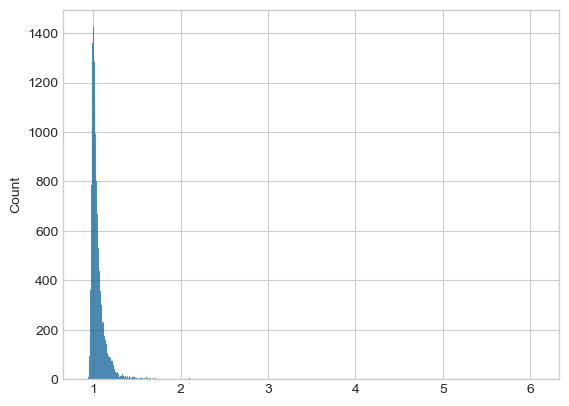

In [155]:
# Menghitung nilai LOF
lof_scores = lof_model.decision_function(credit_raw_1_drop_wo_y_scale_pca)

lof_scores

# Menampilkan distribusi nilai LOF
sns.histplot(lof_scores)

<Axes: >

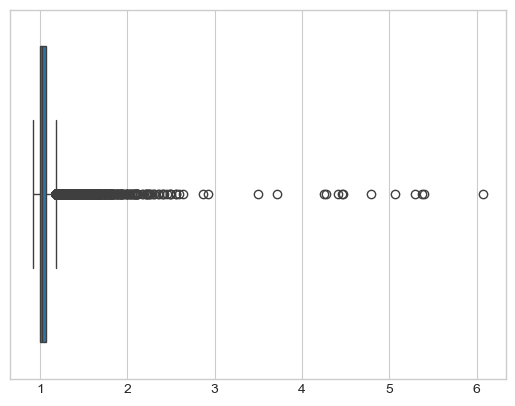

In [156]:
sns.boxplot(lof_scores, orient='h')

## Cek Index Anomali

In [157]:
# cek index yang dideteksi merupakan anomali
anomaly_indices = np.where(lof_label == 1)[0]
anomaly_indices

array([    5,     9,    10, ..., 26456, 26460, 26470], dtype=int64)

## Visualisasi Plot LOF

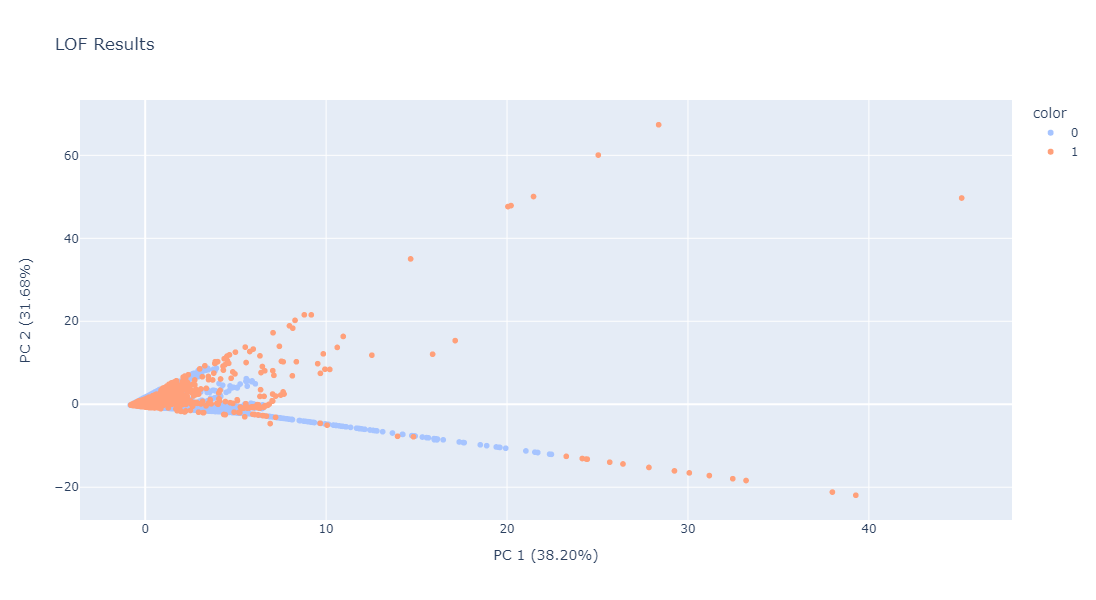

In [158]:
# masukkan nama dataframe PCA ke ___
credit_raw_1_drop_wo_y_scale_pca["color"] = lof_label.astype(str)

# Plot hasil LOF menggunakan Plotly Express
fig = px.scatter(credit_raw_1_drop_wo_y_scale_pca.sort_values("color"), 
                 x='pca0', y='pca1', color="color",
                 color_discrete_map={'0': '#a6c4ff', '1': '#ffa07a'},
                 title='LOF Results',
                 labels={'pca0': f'PC 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)',
                         'pca1': f'PC 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)'})

# Menampilkan plot
fig.update_layout(width=800, height=600)
fig.show()

### Cek Index Anomali

**Interpretasi hasilnya dapat dilakukan sebagai berikut:**

...

..

.
